Detected Anomalies (Heart Rates in bpm):
[71.9 67.4 72.5 71.1 72.2 51.1 56.5 42.  50.9 51.3 53.9 43.8 43.4 52.6
 51.5 78. ]
Number of detected anomalies: 16

True Local Anomalies Detection Status:
Heart Rate 68.0 bpm: Detected? No
Heart Rate 71.9 bpm: Detected? No
Heart Rate 78.0 bpm: Detected? Yes

All ICU Points Detection Status:
Heart Rate 51.1 bpm: Detected? Yes
Heart Rate 56.5 bpm: Detected? Yes
Heart Rate 42.0 bpm: Detected? Yes
Heart Rate 50.9 bpm: Detected? Yes
Heart Rate 51.3 bpm: Detected? Yes
Heart Rate 53.9 bpm: Detected? Yes
Heart Rate 43.8 bpm: Detected? Yes
Heart Rate 43.4 bpm: Detected? Yes
Heart Rate 52.6 bpm: Detected? Yes
Heart Rate 51.5 bpm: Detected? Yes


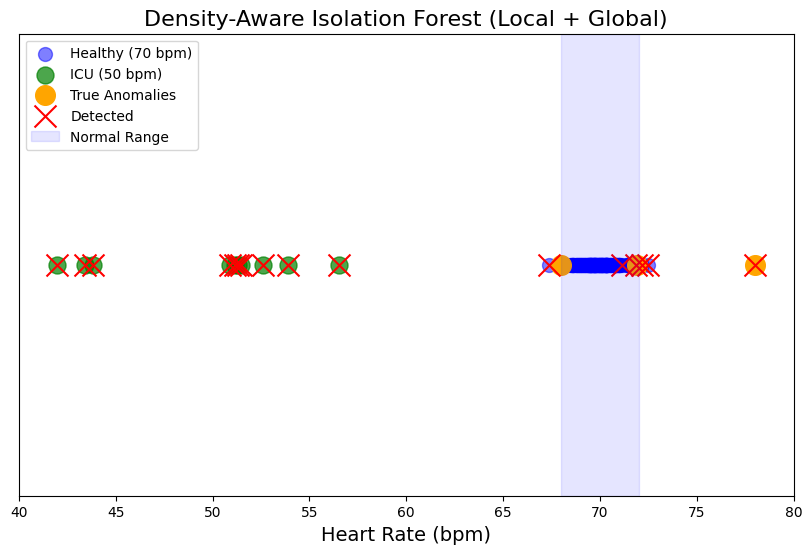

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Step 1: Generate Heart Disease Dataset
np.random.seed(42)
healthy = np.random.normal(70, 1, (140, 1))  # Dense at 70 bpm
icu = np.random.normal(50, 5, (10, 1))
local_anomalies = np.array([[68], [71.9], [78]])
data = np.vstack([healthy, icu, local_anomalies])
true_labels = np.array([0] * 140 + [1] * 10 + [2] * 3)
n_samples = len(data)

# Step 2: Build Isolation Forest
n_trees = 100
iso_forest = IsolationForest(n_estimators=n_trees, max_samples='auto', random_state=42)
iso_forest.fit(data)

# Step 3: Extract Path Lengths and Leaf Densities
path_lengths = np.zeros((n_samples, n_trees))
leaf_densities = np.zeros((n_samples, n_trees))

for tree_idx, tree in enumerate(iso_forest.estimators_):
    paths = tree.decision_path(data).toarray()
    leaves = paths.argmax(axis=1)
    path_lengths[:, tree_idx] = np.sum(paths, axis=1) - 1  # Exact path length
    unique_leaves, counts = np.unique(leaves, return_counts=True)
    for leaf_id, count in zip(unique_leaves, counts):
        leaf_densities[leaves == leaf_id, tree_idx] = count

# Average across trees
avg_path_lengths = np.mean(path_lengths, axis=1)
avg_leaf_densities = np.mean(leaf_densities, axis=1)

# Step 4: Compute Density-Aware Anomaly Score
c_n = 2 * np.log(n_samples - 1) + 0.577  # Normalization factor
base_scores = 2 ** (-avg_path_lengths / c_n)  # Standard score (higher = anomaly)

# Selective density boost: Only for points near normal range (68-72 bpm) in sparse leaves
k = 1.5  # Tuning factor
normal_range = (68, 72)
density_boost = np.where(
    (avg_leaf_densities < 5) & (data.flatten() >= normal_range[0] - 5) & (data.flatten() <= normal_range[1] + 5),
    1 / (avg_leaf_densities + 1e-6),  # Boost for sparse leaves near 70 bpm
    0  # No boost for far-off points (global anomalies)
)
density_scores = base_scores + k * density_boost  # Add density term instead of multiply

# Step 5: Identify Anomalies
threshold = np.percentile(density_scores, 90)  # Top 10% (~15 anomalies)
detected_anomalies = data[density_scores >= threshold]
detected_indices = np.where(density_scores >= threshold)[0]

# Print Results
print("Detected Anomalies (Heart Rates in bpm):")
print(np.round(detected_anomalies.flatten(), 1))
print(f"Number of detected anomalies: {len(detected_anomalies)}")
print("\nTrue Local Anomalies Detection Status:")
for anomaly in local_anomalies:
    detected = "Yes" if anomaly in detected_anomalies else "No"
    print(f"Heart Rate {anomaly[0]} bpm: Detected? {detected}")
print("\nAll ICU Points Detection Status:")
icu_points = icu.flatten()
for anomaly in icu_points:
    detected = "Yes" if anomaly in detected_anomalies.flatten() else "No"
    print(f"Heart Rate {anomaly:.1f} bpm: Detected? {detected}")

# Visualization (for reference)
plt.figure(figsize=(10, 6))
plt.scatter(healthy, [0] * len(healthy), c='blue', label='Healthy (70 bpm)', s=100, alpha=0.5)
plt.scatter(icu, [0] * len(icu), c='green', label='ICU (50 bpm)', s=150, alpha=0.7)
plt.scatter(local_anomalies, [0] * len(local_anomalies), c='orange', label='True Anomalies', s=200)
plt.scatter(detected_anomalies, [0] * len(detected_anomalies), c='red', marker='x', s=250, label='Detected')
plt.axvspan(68, 72, color='blue', alpha=0.1, label='Normal Range')
plt.title('Density-Aware Isolation Forest (Local + Global)', fontsize=16)
plt.xlabel('Heart Rate (bpm)', fontsize=14)
plt.yticks([])
plt.legend(loc='upper left')
plt.xlim(40, 80)
plt.show()

Detected Anomalies (Heart Rates in bpm):
[72.5 56.5 42.  53.9 43.8 43.4 63.  50. ]
Number of detected anomalies: 8

True Local Anomalies Detection Status:
Heart Rate 63.0 bpm: Detected? Yes
Heart Rate 50.0 bpm: Detected? Yes
Heart Rate 71.91 bpm: Detected? No

All ICU Points Detection Status:
Heart Rate 51.1 bpm: Detected? No
Heart Rate 56.5 bpm: Detected? Yes
Heart Rate 42.0 bpm: Detected? Yes
Heart Rate 50.9 bpm: Detected? No
Heart Rate 51.3 bpm: Detected? No
Heart Rate 53.9 bpm: Detected? Yes
Heart Rate 43.8 bpm: Detected? Yes
Heart Rate 43.4 bpm: Detected? Yes
Heart Rate 52.6 bpm: Detected? No
Heart Rate 51.5 bpm: Detected? No


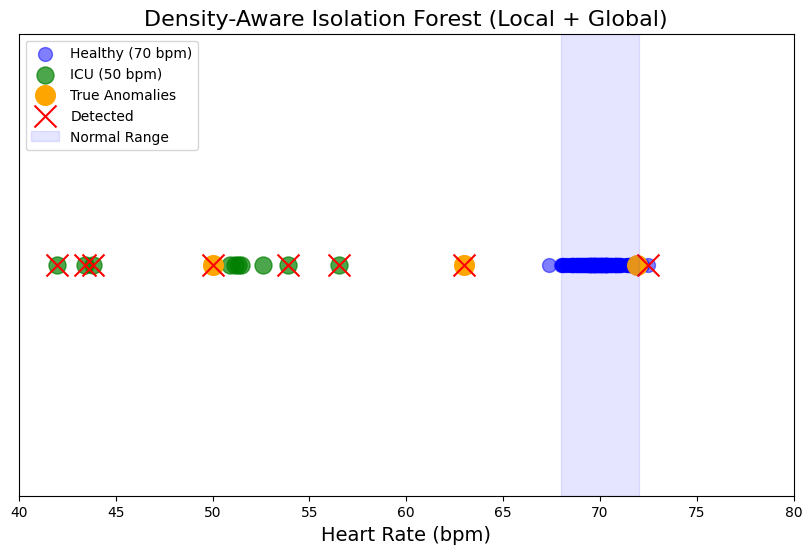

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Step 1: Generate Heart Disease Dataset (Base Case)
np.random.seed(42)
healthy = np.random.normal(70, 1, (140, 1))  # Dense at 70 bpm
icu = np.random.normal(50, 5, (10, 1))      # Sparse at 50 bpm
local_anomalies = np.array([[63], [50], [71.91]])  # Local anomalies
data = np.vstack([healthy, icu, local_anomalies])
true_labels = np.array([0] * 140 + [1] * 10 + [2] * 3)
n_samples = len(data)

# Step 2: Build Isolation Forest
n_trees = 100
iso_forest = IsolationForest(n_estimators=n_trees, max_samples='auto', random_state=42)
iso_forest.fit(data)

# Step 3: Extract Path Lengths and Leaf Densities
path_lengths = np.zeros((n_samples, n_trees))
leaf_densities = np.zeros((n_samples, n_trees))

for tree_idx, tree in enumerate(iso_forest.estimators_):
    paths = tree.decision_path(data).toarray()
    leaves = paths.argmax(axis=1)
    path_lengths[:, tree_idx] = np.sum(paths, axis=1) - 1
    unique_leaves, counts = np.unique(leaves, return_counts=True)
    for leaf_id, count in zip(unique_leaves, counts):
        leaf_densities[leaves == leaf_id, tree_idx] = count

# Average across trees
avg_path_lengths = np.mean(path_lengths, axis=1)
avg_leaf_densities = np.mean(leaf_densities, axis=1)

# Step 4: Compute Density-Aware Anomaly Score
c_n = 2 * np.log(n_samples - 1) + 0.577
base_scores = 2 ** (-avg_path_lengths / c_n)  # Higher = more anomalous
k = 1.0  # Tuning factor
normal_range = (68, 72)

# Density boost only for sparse leaves OUTSIDE normal range or far-off points
density_boost = np.where(
    (avg_leaf_densities < 5) &
    ((data.flatten() < normal_range[0] - 2) | (data.flatten() > normal_range[1] + 2)),
    1 / (avg_leaf_densities + 1e-6),
    0
)
density_scores = base_scores + k * density_boost

# Cap scores for normal range points to avoid false positives
density_scores = np.where(
    (data.flatten() >= normal_range[0]) & (data.flatten() <= normal_range[1]),
    np.minimum(density_scores, 0.5),  # Cap at 0.5 for normal points
    density_scores
)

# Step 5: Identify Anomalies
threshold = np.percentile(density_scores, 95)  # Top 5% (~7-8 anomalies)
detected_anomalies = data[density_scores >= threshold]
detected_indices = np.where(density_scores >= threshold)[0]

# Print Results
print("Detected Anomalies (Heart Rates in bpm):")
print(np.round(detected_anomalies.flatten(), 1))
print(f"Number of detected anomalies: {len(detected_anomalies)}")
print("\nTrue Local Anomalies Detection Status:")
for anomaly in local_anomalies:
    detected = "Yes" if anomaly in detected_anomalies else "No"
    print(f"Heart Rate {anomaly[0]} bpm: Detected? {detected}")
print("\nAll ICU Points Detection Status:")
icu_points = icu.flatten()
for anomaly in icu_points:
    detected = "Yes" if anomaly in detected_anomalies.flatten() else "No"
    print(f"Heart Rate {anomaly:.1f} bpm: Detected? {detected}")

# Visualization (for reference)
plt.figure(figsize=(10, 6))
plt.scatter(healthy, [0] * len(healthy), c='blue', label='Healthy (70 bpm)', s=100, alpha=0.5)
plt.scatter(icu, [0] * len(icu), c='green', label='ICU (50 bpm)', s=150, alpha=0.7)
plt.scatter(local_anomalies, [0] * len(local_anomalies), c='orange', label='True Anomalies', s=200)
plt.scatter(detected_anomalies, [0] * len(detected_anomalies), c='red', marker='x', s=250, label='Detected')
plt.axvspan(68, 72, color='blue', alpha=0.1, label='Normal Range')
plt.title('Density-Aware Isolation Forest (Local + Global)', fontsize=16)
plt.xlabel('Heart Rate (bpm)', fontsize=14)
plt.yticks([])
plt.legend(loc='upper left')
plt.xlim(40, 80)
plt.show()

Detected Anomalies (Heart Rates in bpm):
[71.9 67.4 71.9 72.5 72.2 51.1 56.5 42.  50.9 51.3 53.9 43.8 43.4 52.6
 51.5 63. ]
Number of detected anomalies: 16

True Local Anomalies Detection Status:
Heart Rate 63 bpm: Detected? Yes
Heart Rate 69 bpm: Detected? No
Heart Rate 71 bpm: Detected? No

All ICU Points Detection Status:
Heart Rate 51.1 bpm: Detected? Yes
Heart Rate 56.5 bpm: Detected? Yes
Heart Rate 42.0 bpm: Detected? Yes
Heart Rate 50.9 bpm: Detected? Yes
Heart Rate 51.3 bpm: Detected? Yes
Heart Rate 53.9 bpm: Detected? Yes
Heart Rate 43.8 bpm: Detected? Yes
Heart Rate 43.4 bpm: Detected? Yes
Heart Rate 52.6 bpm: Detected? Yes
Heart Rate 51.5 bpm: Detected? Yes


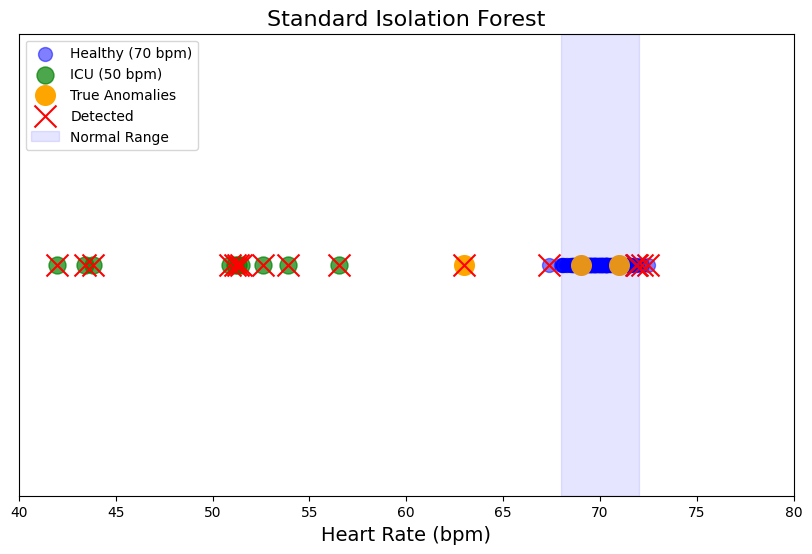

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Step 1: Generate Heart Disease Dataset
np.random.seed(42)
healthy = np.random.normal(70, 1, (140, 1))  # Dense at 70 bpm
icu = np.random.normal(50, 5, (10, 1))      # Sparse at 50 bpm
local_anomalies = np.array([[63], [69], [71]])  # Local anomalies
data = np.vstack([healthy, icu, local_anomalies])
true_labels = np.array([0] * 140 + [1] * 10 + [2] * 3)
n_samples = len(data)

# Step 2: Build Standard Isolation Forest
n_trees = 100
iso_forest = IsolationForest(n_estimators=n_trees, max_samples='auto', contamination=0.1, random_state=42)
iso_forest.fit(data)

# Step 3: Compute Anomaly Scores
# Negative decision_function = path length approximation, lower = more anomalous
scores = iso_forest.decision_function(data)  # Positive = normal, negative = anomaly
anomaly_labels = iso_forest.predict(data)  # -1 = anomaly, 1 = normal
detected_anomalies = data[anomaly_labels == -1]

# Step 4: Print Results
print("Detected Anomalies (Heart Rates in bpm):")
print(np.round(detected_anomalies.flatten(), 1))
print(f"Number of detected anomalies: {len(detected_anomalies)}")
print("\nTrue Local Anomalies Detection Status:")
for anomaly in local_anomalies:
    detected = "Yes" if anomaly in detected_anomalies else "No"
    print(f"Heart Rate {anomaly[0]} bpm: Detected? {detected}")
print("\nAll ICU Points Detection Status:")
icu_points = icu.flatten()
for anomaly in icu_points:
    detected = "Yes" if anomaly in detected_anomalies.flatten() else "No"
    print(f"Heart Rate {anomaly:.1f} bpm: Detected? {detected}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(healthy, [0] * len(healthy), c='blue', label='Healthy (70 bpm)', s=100, alpha=0.5)
plt.scatter(icu, [0] * len(icu), c='green', label='ICU (50 bpm)', s=150, alpha=0.7)
plt.scatter(local_anomalies, [0] * len(local_anomalies), c='orange', label='True Anomalies', s=200)
plt.scatter(detected_anomalies, [0] * len(detected_anomalies), c='red', marker='x', s=250, label='Detected')
plt.axvspan(68, 72, color='blue', alpha=0.1, label='Normal Range')
plt.title('Standard Isolation Forest', fontsize=16)
plt.xlabel('Heart Rate (bpm)', fontsize=14)
plt.yticks([])
plt.legend(loc='upper left')
plt.xlim(40, 80)
plt.show()